In [36]:
import os
from pathlib import Path, PureWindowsPath
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [37]:
os.path.dirname(os.getcwd())

'C:\\Users\\alecb\\Projects\\capstone\\Store-Sales'

In [38]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd

WindowsPath('C:/Users/alecb/Projects/capstone/Store-Sales')

In [39]:
path = path_cwd / 'data'
path

WindowsPath('C:/Users/alecb/Projects/capstone/Store-Sales/data')

In [40]:
path / 'train'

WindowsPath('C:/Users/alecb/Projects/capstone/Store-Sales/data/train')

In [41]:
df_train = pd.read_csv(path / 'train.csv')
df_transaction = pd.read_csv(path / 'transactions.csv')
df_holidays = pd.read_csv(path / 'holidays_events.csv')
df_oil = pd.read_csv(path / 'oil.csv')
df_stores = pd.read_csv(path / 'stores.csv')
df_test = pd.read_csv(path / 'test.csv')

# Discovery

### Field Descriptions
1. train.csv
* The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
* store_nbr identifies the store at which the products are sold. (Even amount: 55572 each)
* family identifies the type of product sold. (Even amount: 90,926 each)
* sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
2. test.csv
* The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
* The dates in the test data are for the 15 days after the last date in the training data.
3. sample_submission.csv
* A sample submission file in the correct format.
4. stores.csv
* Store metadata, including city, state, type, and cluster.
* cluster is a grouping of similar stores.
5. oil.csv
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
6. holidays_events.csv
* Holidays and Events, with metadata
* NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
7. Additional Notes
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### Ideas
* Does oil prices have any indication of store sales? Feature of oil price feed into store sales forecast
* Location of stores should we taken into consideration, and treated seperately

# Oil Exploration

In [54]:
df_oil['date'] = pd.to_datetime(df_oil['date'], errors = 'coerce')

In [57]:
# Set the 'date' column as the index (optional but can be helpful for plotting)
df_oil.set_index('date', inplace=True)

# Sort the DataFrame by date (optional but can be helpful for plotting)
df_oil.sort_index(inplace=True)

# Plotting
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df_oil.index, df_oil['dcoilwtico'], color='blue', marker='o', linestyle='-')  # Plotting the data
plt.title('WTI Crude Oil Prices Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('WTI Crude Oil Price (USD)')  # Y-axis label
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the plo

In [70]:
df_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
df_daily_sales['date'] = pd.to_datetime(df_daily_sales['date'])
#use rolling avg for SARIMA
df_daily_sales['rolling_average_7_day'] = df_daily_sales['sales'].rolling(window=7).mean() 

#Set index to be date
df_daily_sales.set_index('date', inplace=True)
df_daily_sales.sort_index(inplace=True)

In [107]:
df_daily_sales

sales  rolling_average_7_day
date                                            
2013-01-01    2511.618999                    NaN
2013-01-02  496092.417944                    NaN
2013-01-03  361461.231124                    NaN
2013-01-04  354459.677093                    NaN
2013-01-05  477350.121229                    NaN
...                   ...                    ...
2017-08-11  826373.722022          820340.633670
2017-08-12  792630.535079          795617.331469
2017-08-13  865639.677471          769343.119068
2017-08-14  760922.406081          764122.753677
2017-08-15  762661.935939          770536.408939

[1684 rows x 2 columns]

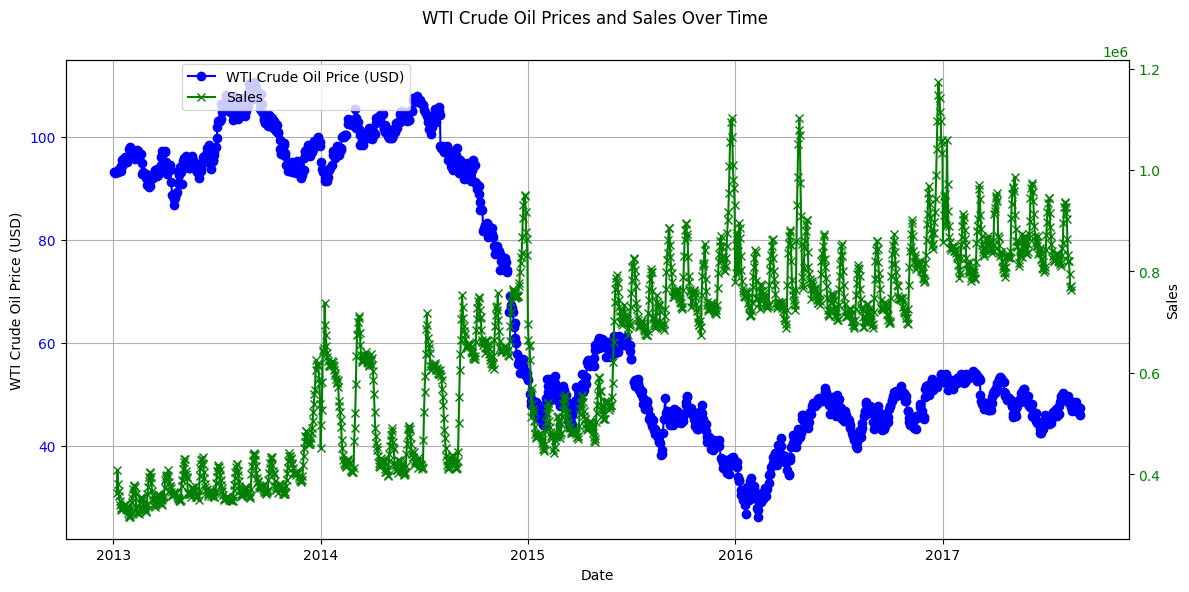

In [71]:
# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot WTI Crude Oil prices
ax1.plot(df_oil.index, df_oil['dcoilwtico'], color='blue', marker='o', linestyle='-', label='WTI Crude Oil Price (USD)')
ax1.set_xlabel('Date')
ax1.set_ylabel('WTI Crude Oil Price (USD)')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot sales data
ax2.plot(df_daily_sales.index, df_daily_sales['rolling_average_7_day'], color='green', marker='x', linestyle='-', label='Sales')
ax2.set_ylabel('Sales')
ax2.tick_params(axis='y', labelcolor='green')

# Title and legend
fig.suptitle('WTI Crude Oil Prices and Sales Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

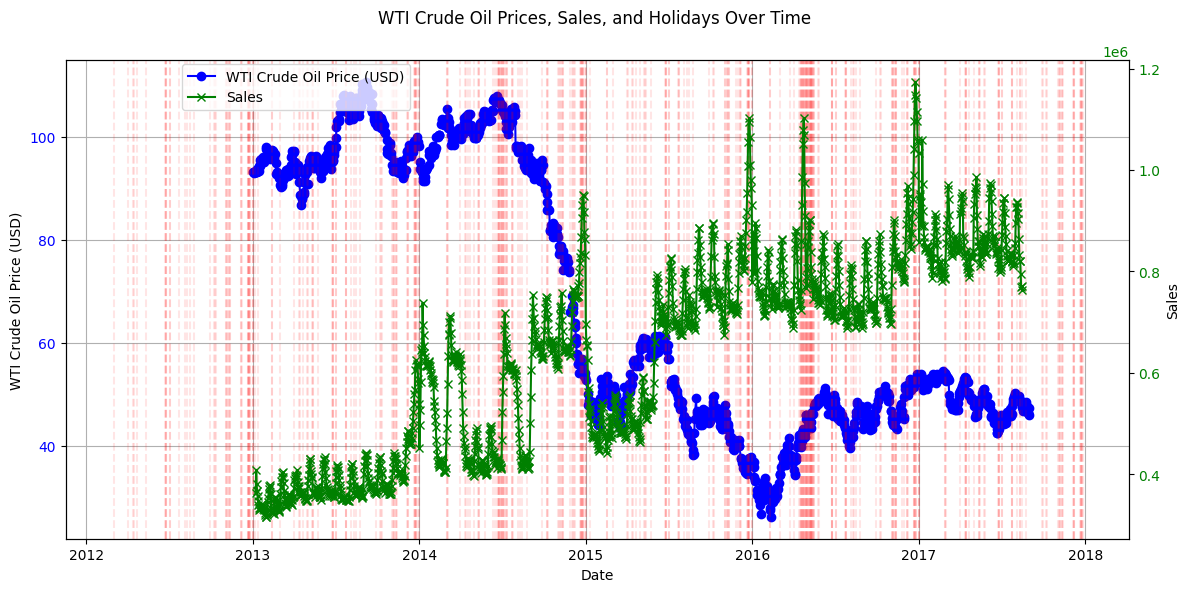

In [103]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot WTI Crude Oil prices
ax1.plot(df_oil.index, df_oil['dcoilwtico'], color='blue', marker='o', linestyle='-', label='WTI Crude Oil Price (USD)')
ax1.set_xlabel('Date')
ax1.set_ylabel('WTI Crude Oil Price (USD)')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot sales data
ax2.plot(df_daily_sales.index, df_daily_sales['rolling_average_7_day'], color='green', marker='x', linestyle='-', label='Sales')
ax2.set_ylabel('Sales')
ax2.tick_params(axis='y', labelcolor='green')

# Mark holidays
for holiday_date in df_holidays['date']:
    ax1.axvline(x=holiday_date, color='red', linestyle='--', alpha=0.1)
    #ax2.axvline(x=holiday_date, color='red', linestyle='--', alpha=0.1)

# Title and legend
fig.suptitle('WTI Crude Oil Prices, Sales, and Holidays Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Notes 
* Seems there could be some correlation between oil and total sales, but not clear. Could be worth splitting out the categories to see further trends

In [84]:
df_daily_sales_by_family = df_train.groupby(['date', 'family'])['sales'].sum().reset_index()

In [105]:
df_train

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [85]:
df_daily_sales_by_family['date'] = pd.to_datetime(df_daily_sales_by_family['date'])
#use rolling avg for SARIMA
df_daily_sales_by_family['rolling_average_7_day'] = df_daily_sales_by_family['sales'].rolling(window=7).mean() 

# #Set index to be date
# df_daily_sales_by_family.set_index('date', inplace=True)
# df_daily_sales_by_family.sort_index(inplace=True)

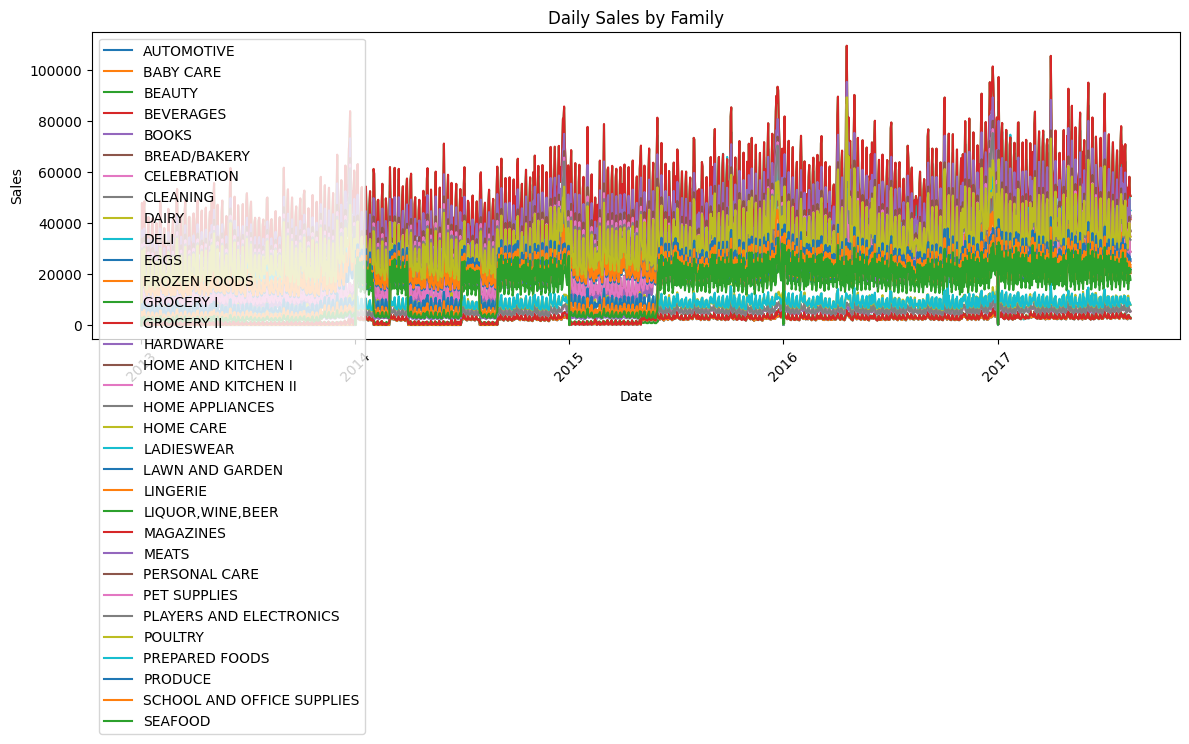

In [86]:
# Create a separate plot for each family
fig, ax = plt.subplots(figsize=(12, 6))

# Group the DataFrame by 'family' and iterate through each group to plot
for family, data in df_daily_sales_by_family.groupby('family'):
    ax.plot(data['date'], data['rolling_average_7_day'], label=family)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Daily Sales by Family')
ax.legend()  # Add legend to differentiate between different families

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

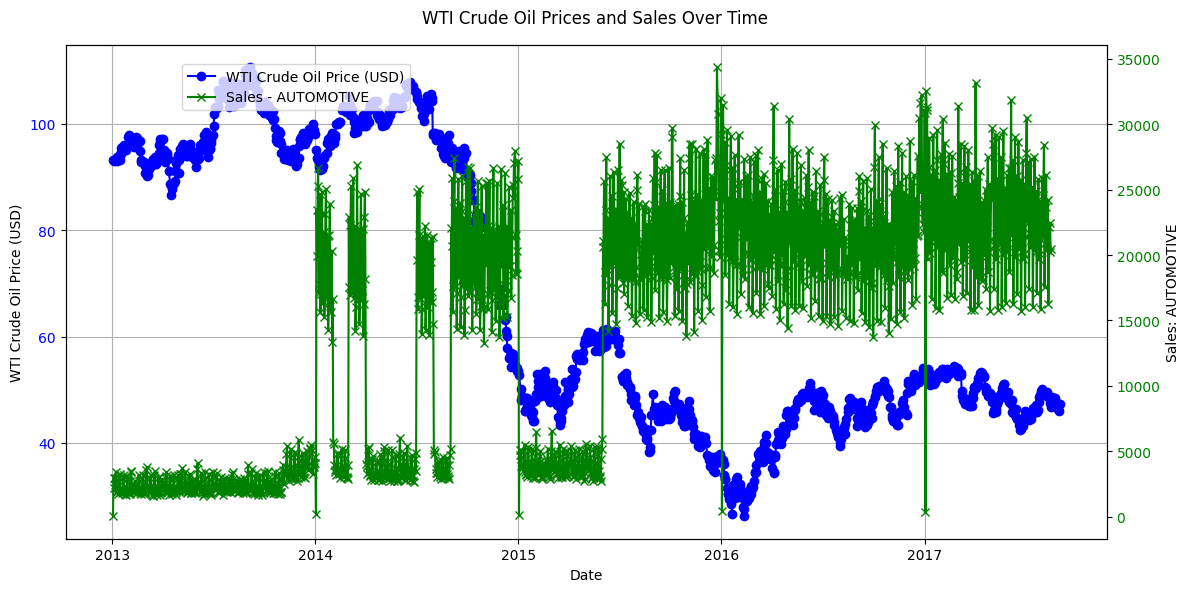

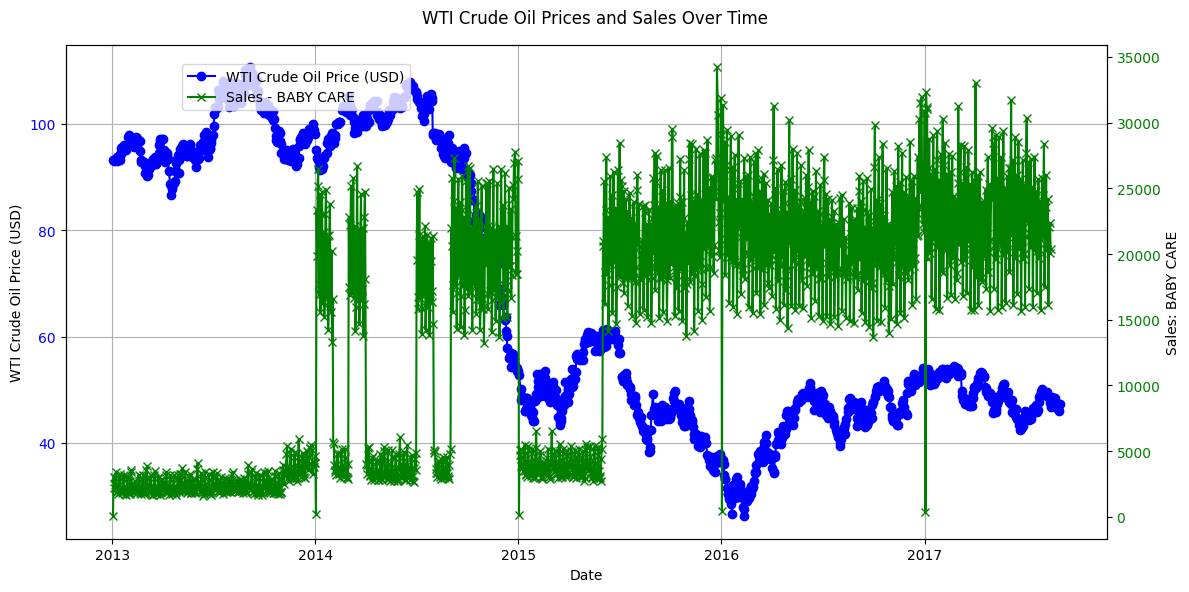

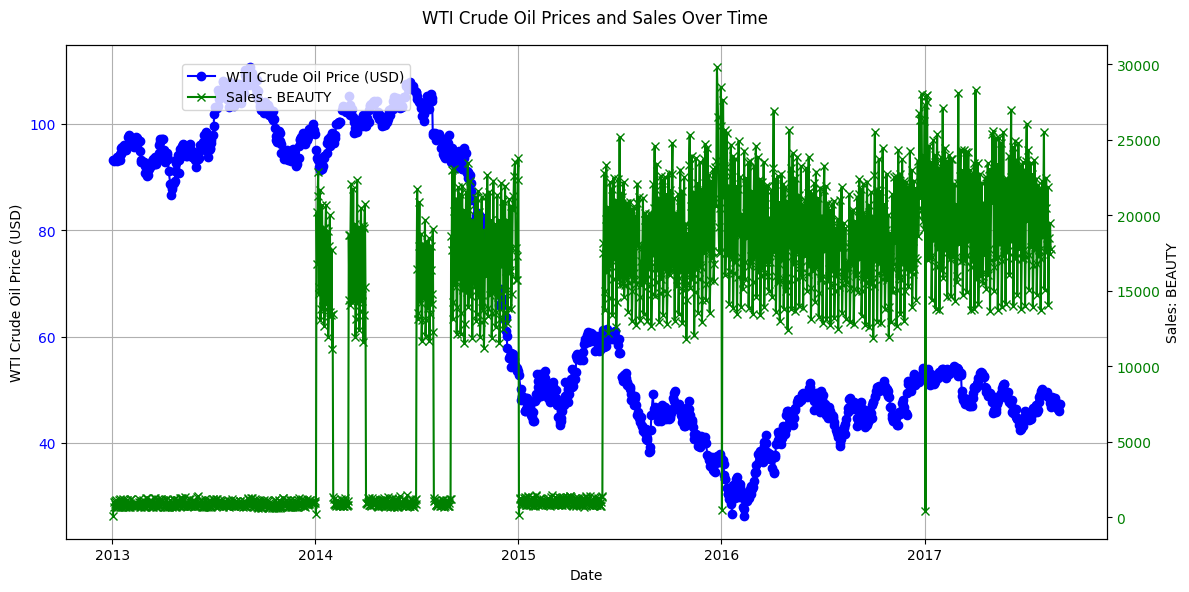

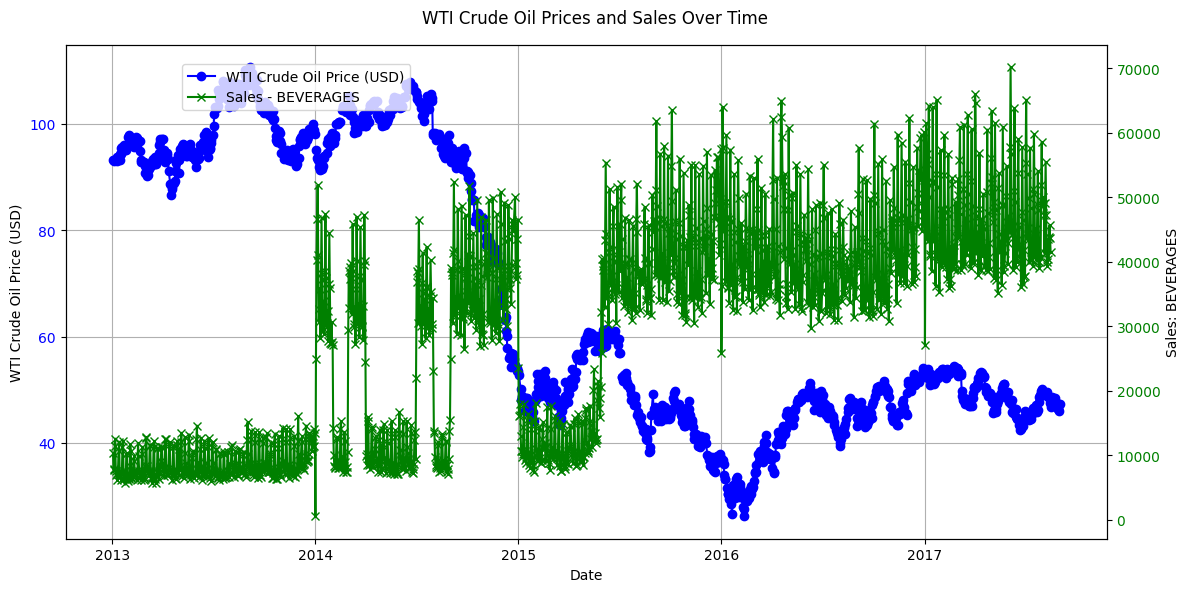

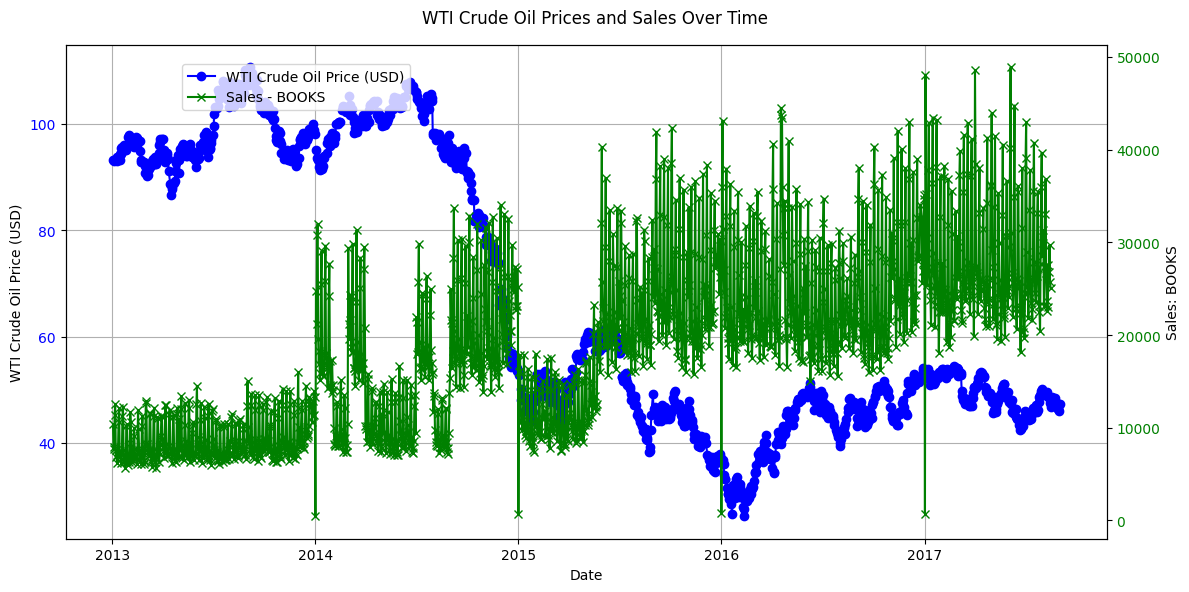

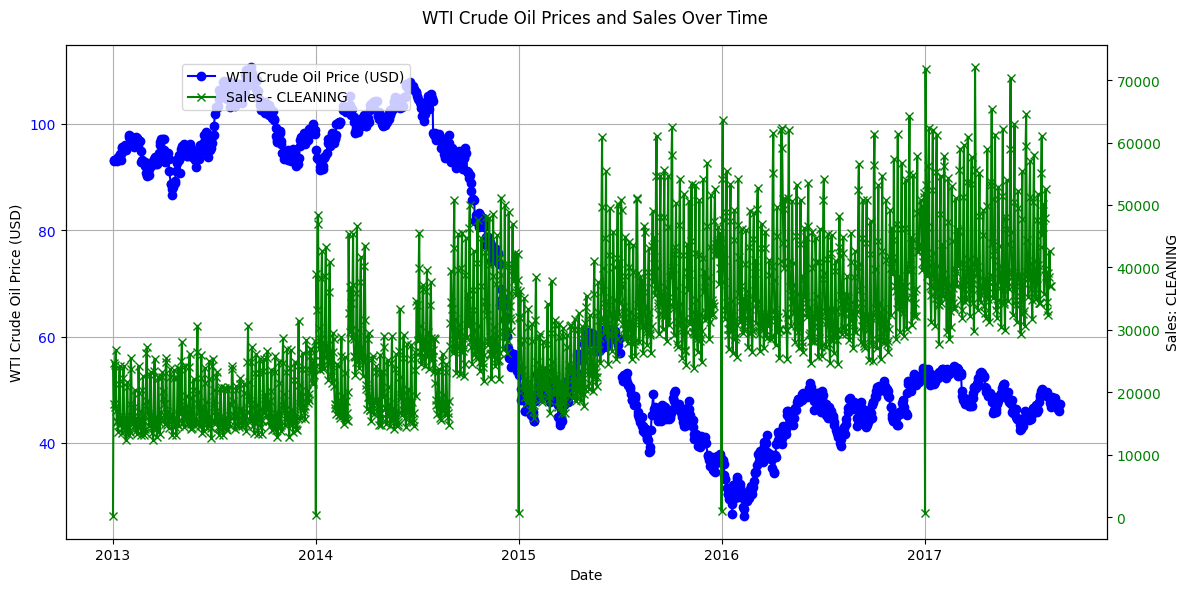

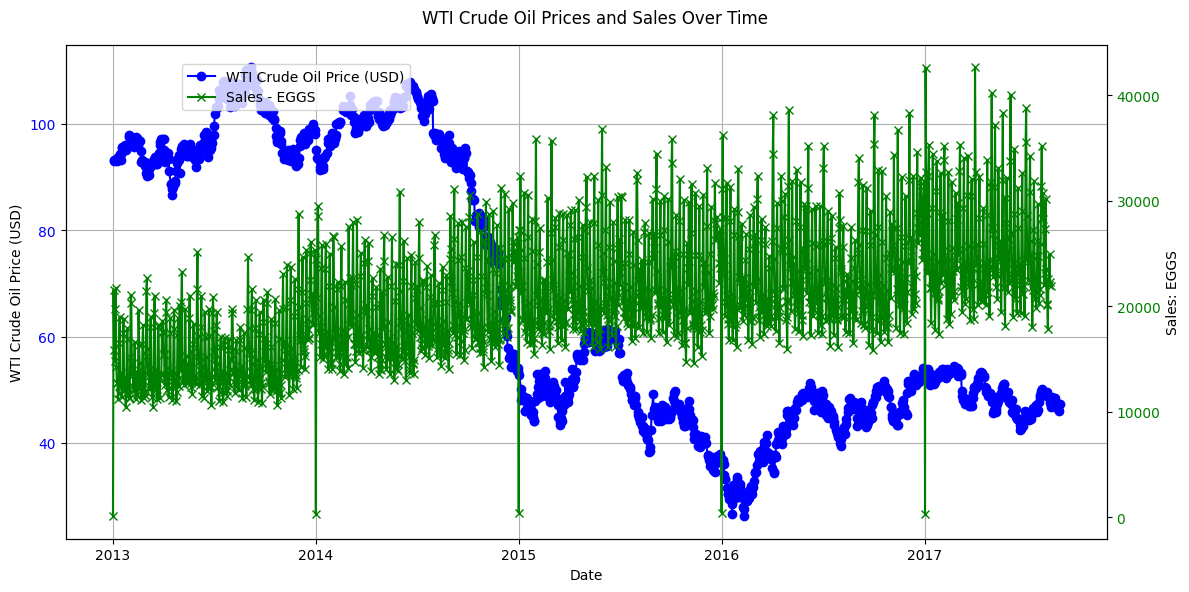

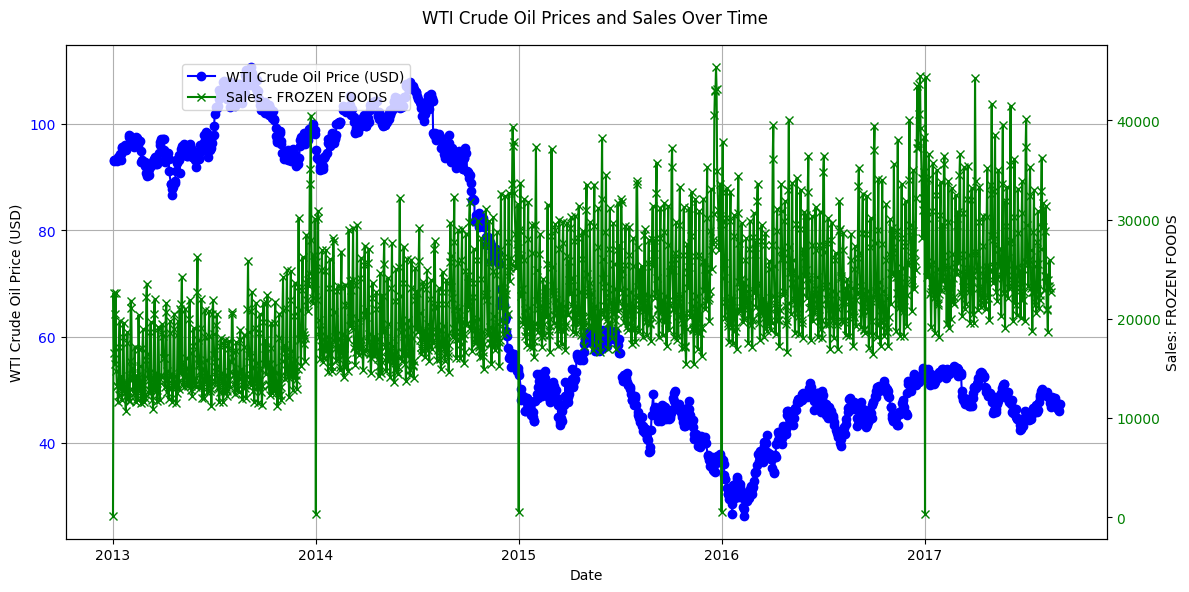

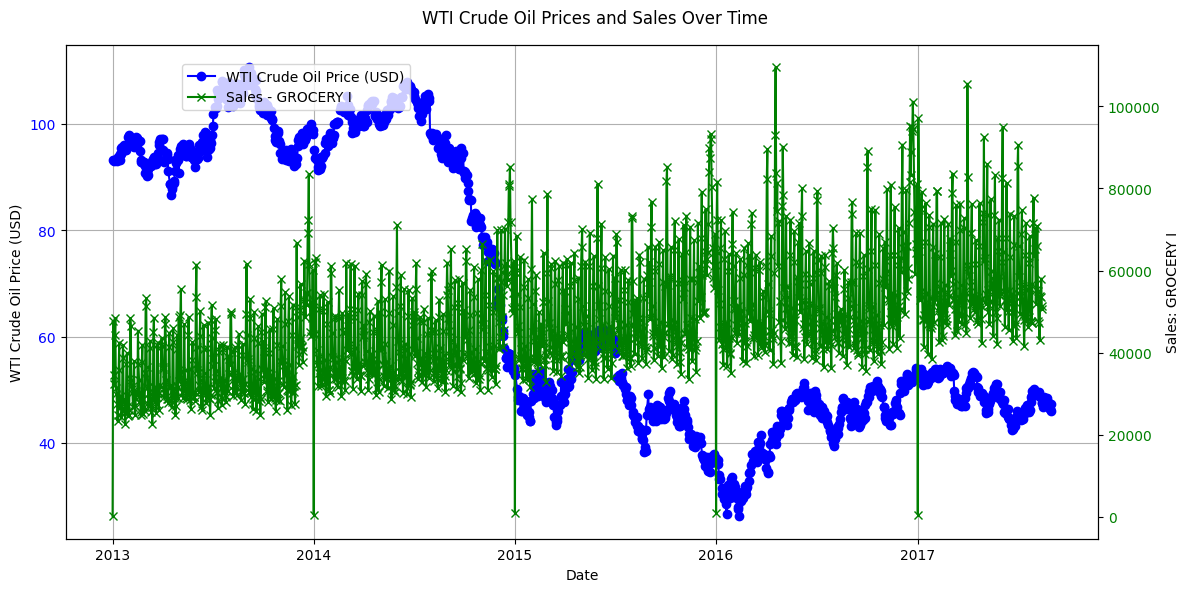

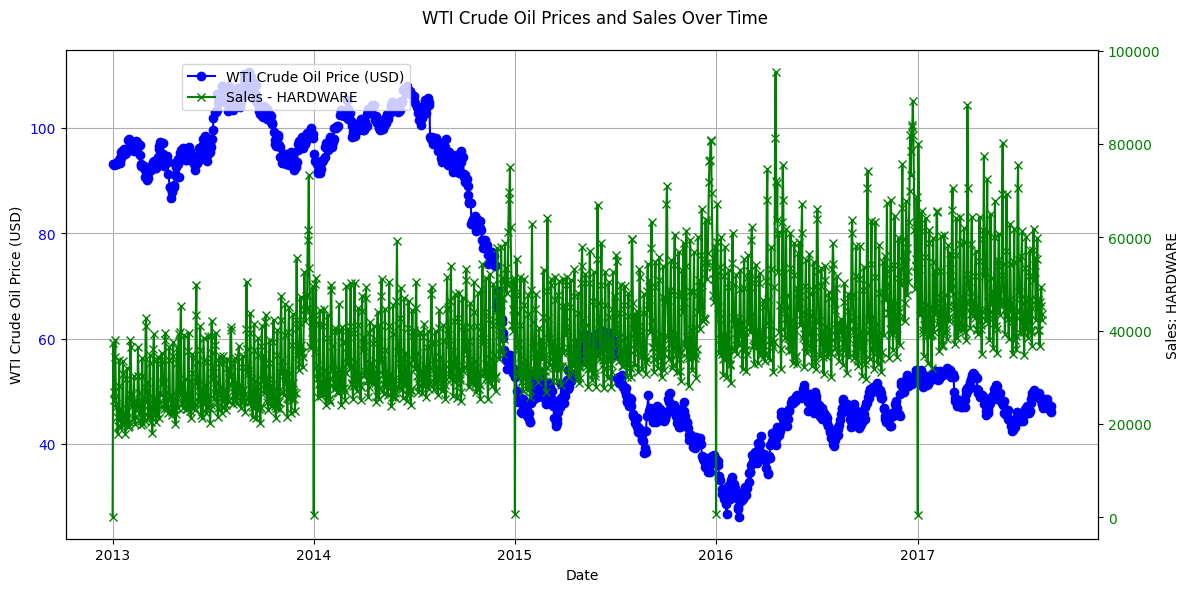

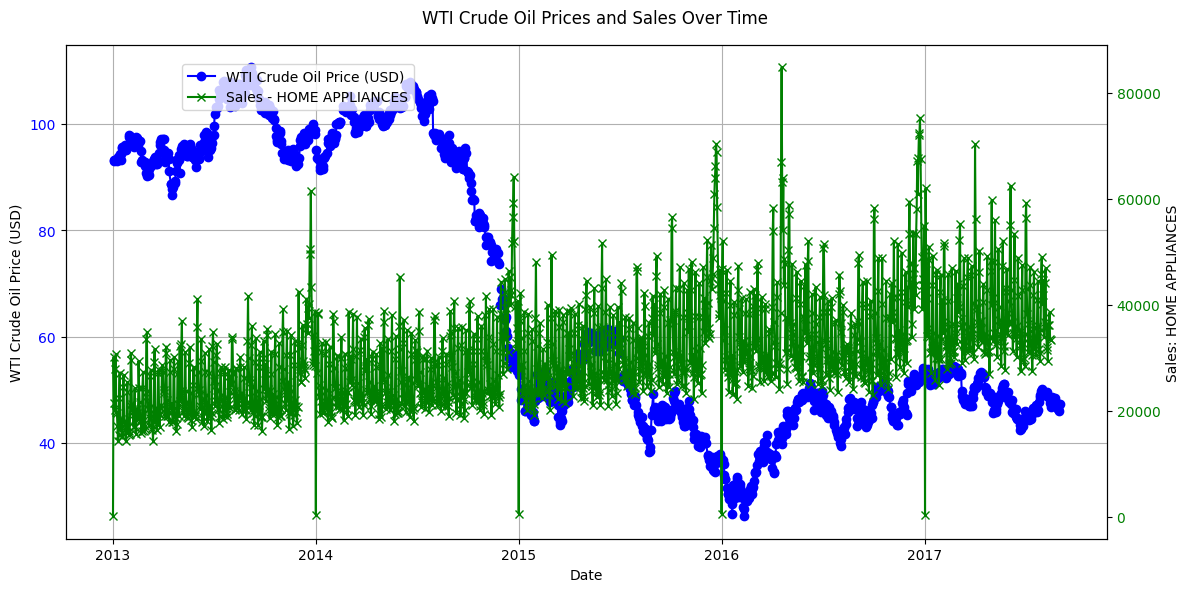

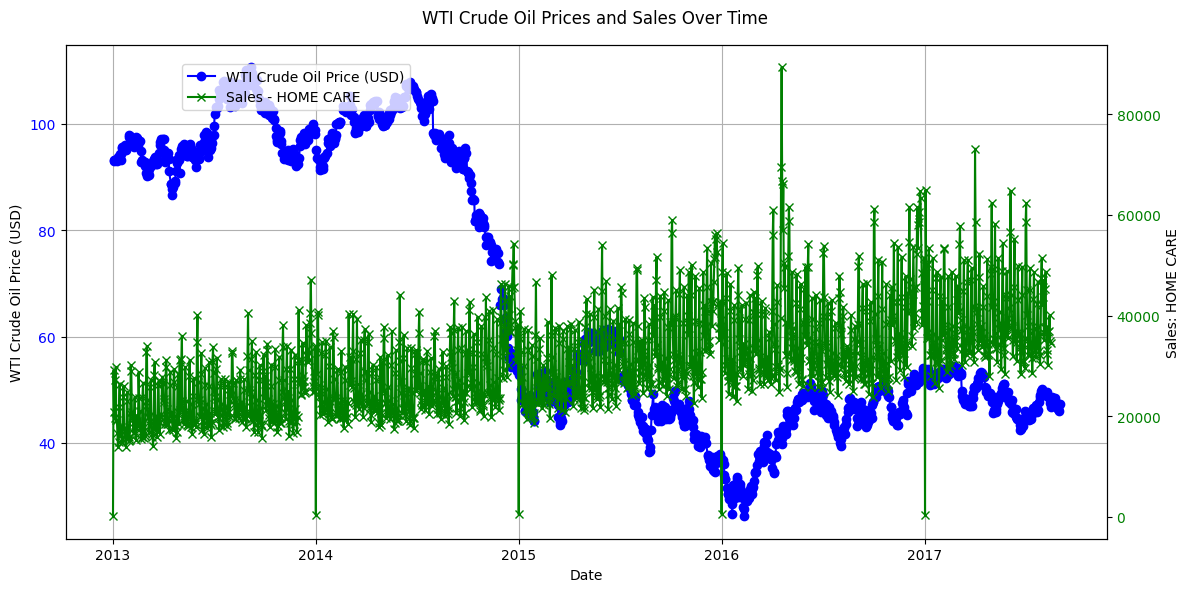

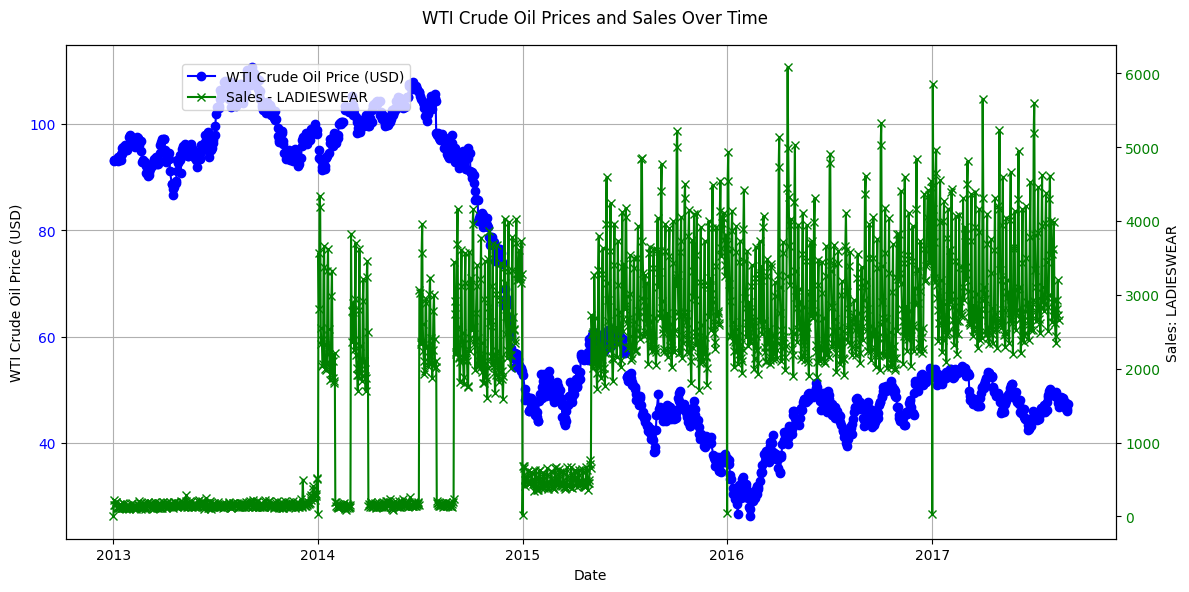

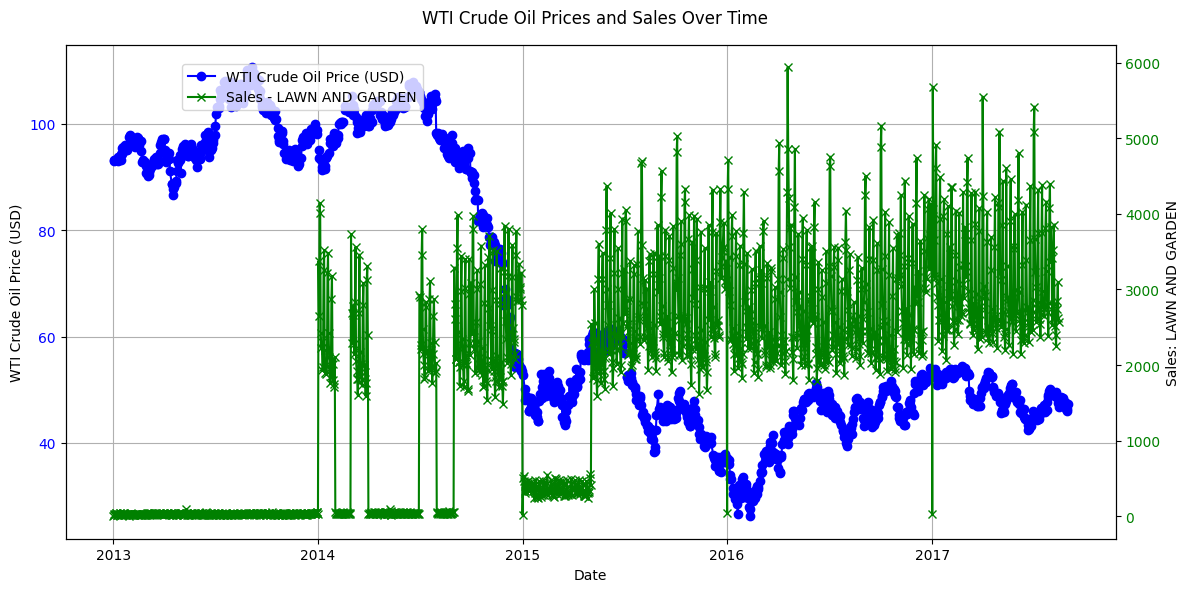

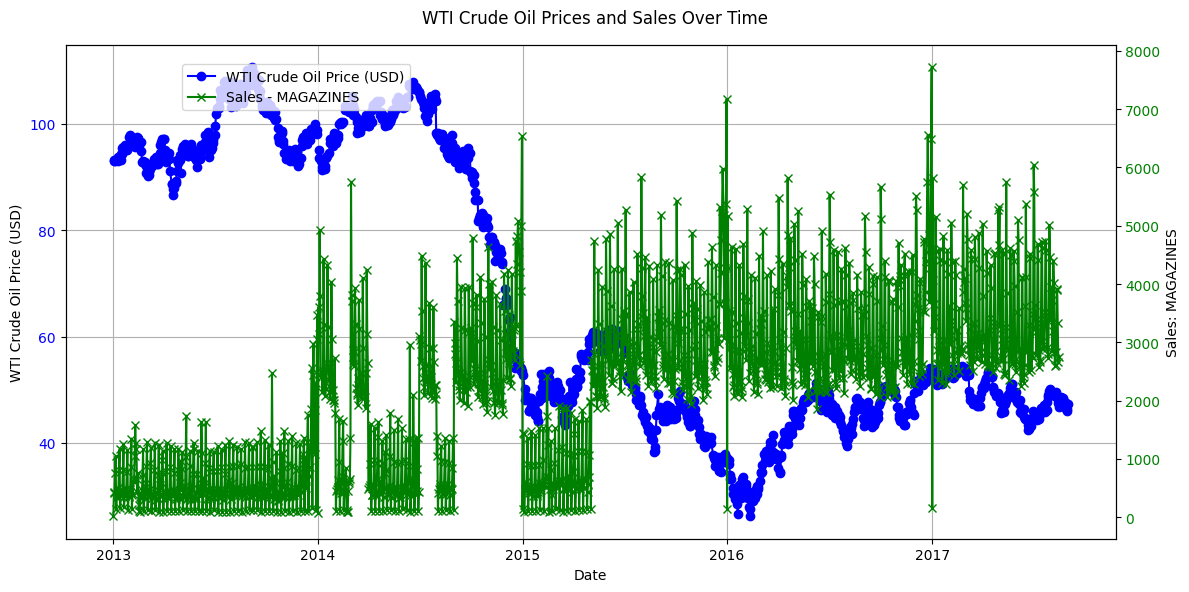

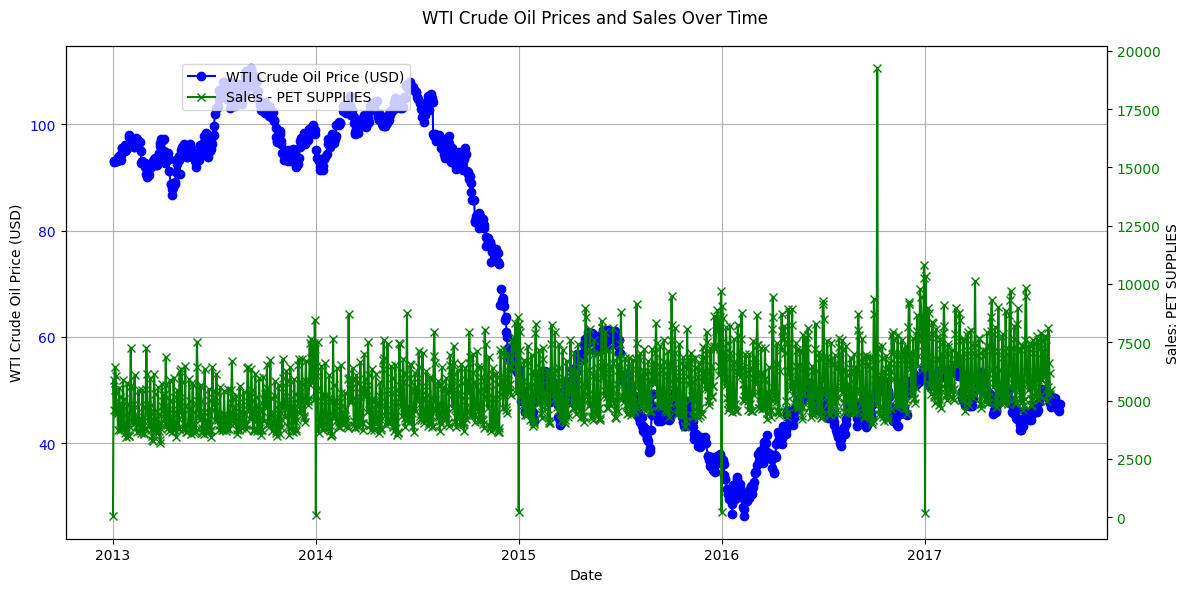

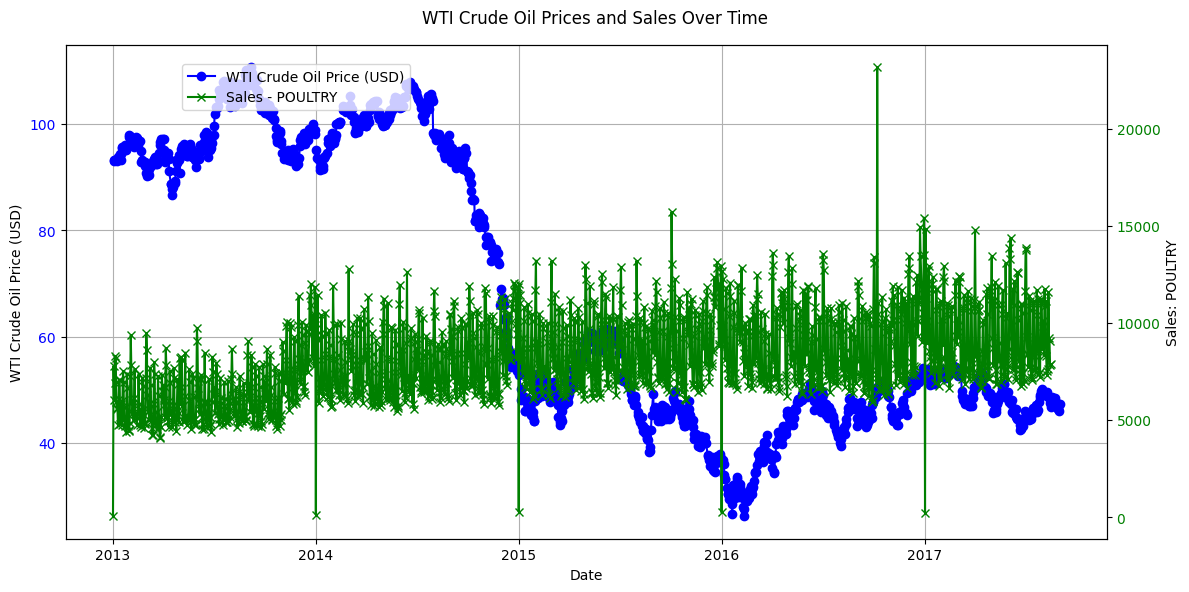

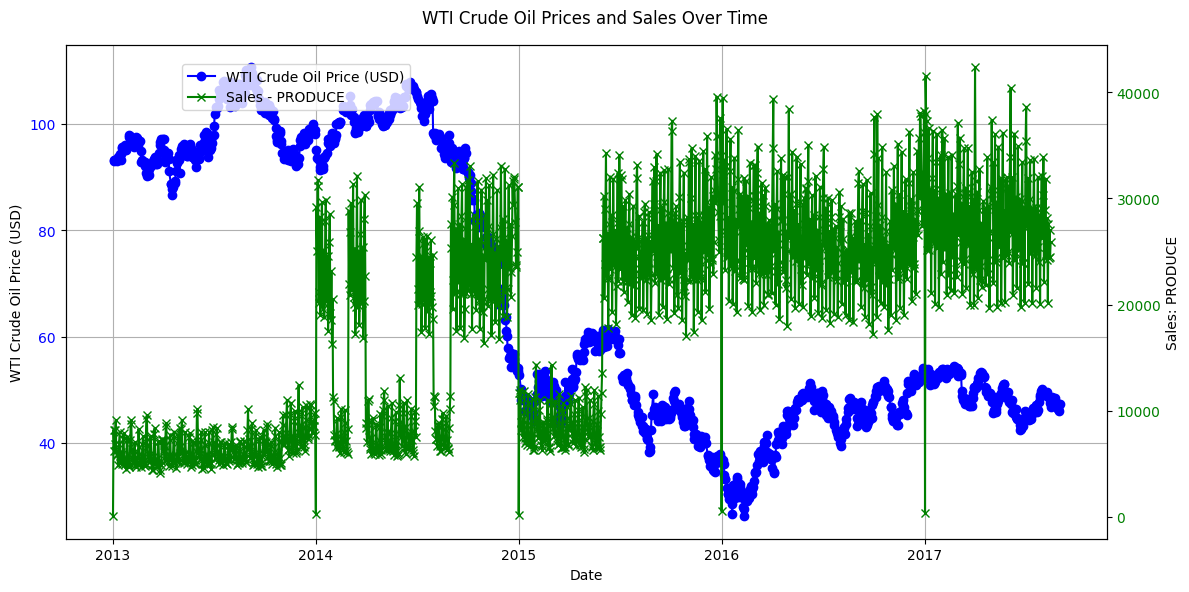

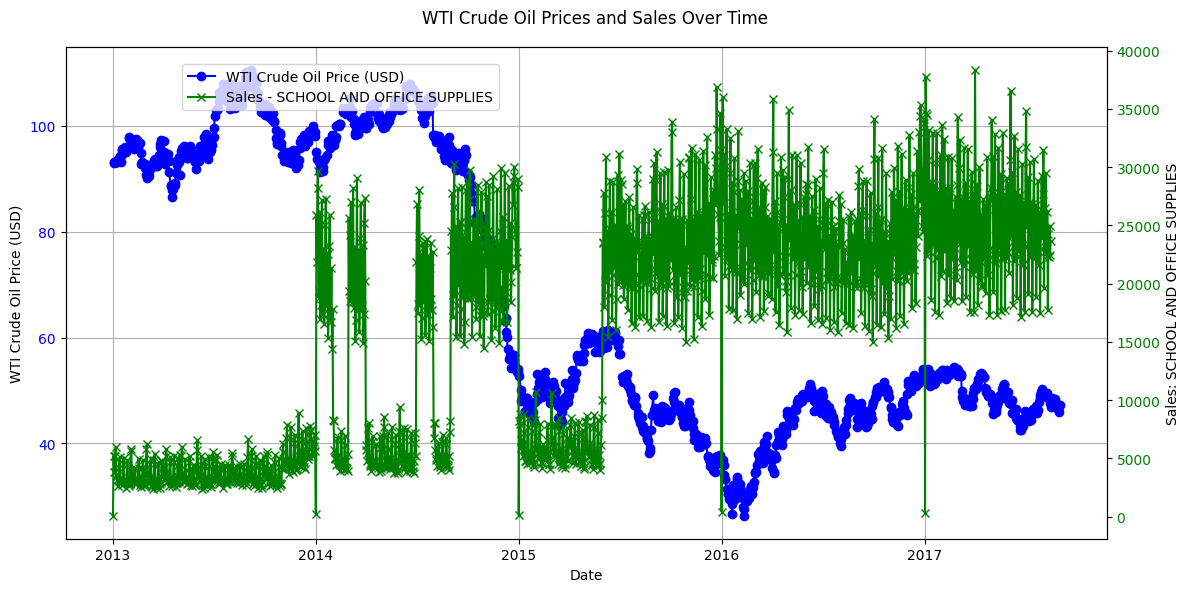

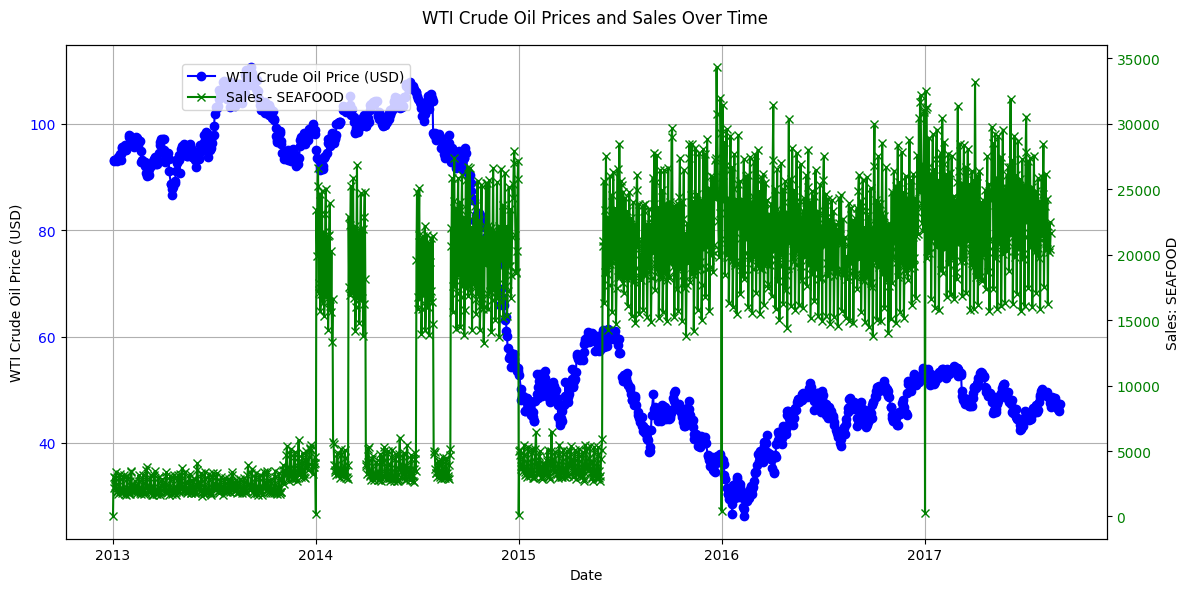

In [96]:
# Assuming you have df_oil and df_daily_sales_by_family DataFrames
for i in df_daily_sales_by_family['family'].unique():
    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot WTI Crude Oil prices
    ax1.plot(df_oil.index, df_oil['dcoilwtico'], color='blue', marker='o', linestyle='-', label='WTI Crude Oil Price (USD)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('WTI Crude Oil Price (USD)')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Create a twin axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Choose the family you want to compare
    family_to_compare = i  # Specify the family name you want to compare

    # Filter sales data for the chosen family
    df_sales_family = df_daily_sales_by_family[df_daily_sales_by_family['family'] == family_to_compare]

    # Plot sales data for the chosen family
    ax2.plot(df_sales_family['date'], df_sales_family['rolling_average_7_day'], color='green', marker='x', linestyle='-', label=f'Sales - {family_to_compare}')
    ax2.set_ylabel('Sales: ' + family_to_compare)
    ax2.tick_params(axis='y', labelcolor='green')

    # Title and legend
    fig.suptitle('WTI Crude Oil Prices and Sales Over Time')
    fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Holidays

In [104]:
# Convert the 'date' column to datetime type
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Extract the year from the 'date' column
df_holidays['year'] = df_holidays['date'].dt.year

# Group by 'year' and count the number of holidays in each year
holiday_counts_per_year = df_holidays.groupby('year').size()

print(holiday_counts_per_year)

year
2012    41
2013    51
2014    67
2015    52
2016    86
2017    53
dtype: int64


# General Exploratory

In [31]:
df_train['family'].count()

3000888

1     55572
46    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
47    55572
10    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
35    55572
34    55572
33    55572
32    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
9     55572
Name: store_nbr, dtype: int64


<AxesSubplot: xlabel='family', ylabel='count'>

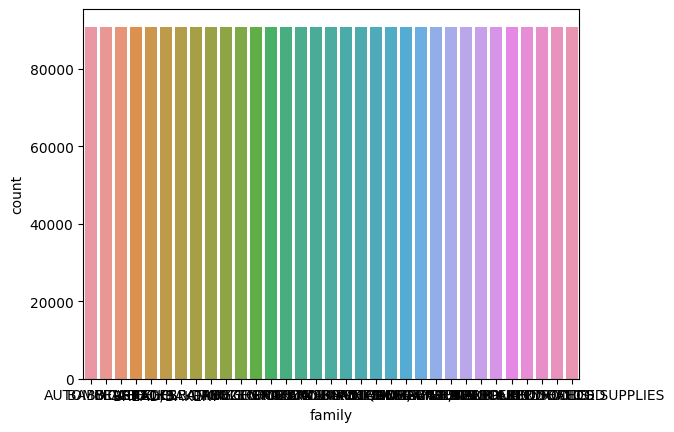

In [35]:
# Most sold products
print(df_train['store_nbr'].value_counts())
sns.countplot(x='family', data=df_train)

# Clean Data

In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [67]:
print('max:',df_train['date'].max(), 'min:',df_train['date'].min())

max: 2017-08-15 min: 2013-01-01


In [14]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [15]:
#add time element features
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['day_name'] = df_train['date'].dt.day_name()
df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year


## Check for seasonality

In [122]:
df_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
df_monthly_sales = df_train.groupby(['year','month'])['sales'].sum().reset_index()
df_monthly_sales_by_store = df_train.groupby(['year','month', 'store_nbr'])['sales'].sum().reset_index()

In [ ]:
#use rolling avg for SARIMA
df_daily_sales['rolling_average_7_day'] = df_daily_sales['sales'].rolling(window=7).mean() 

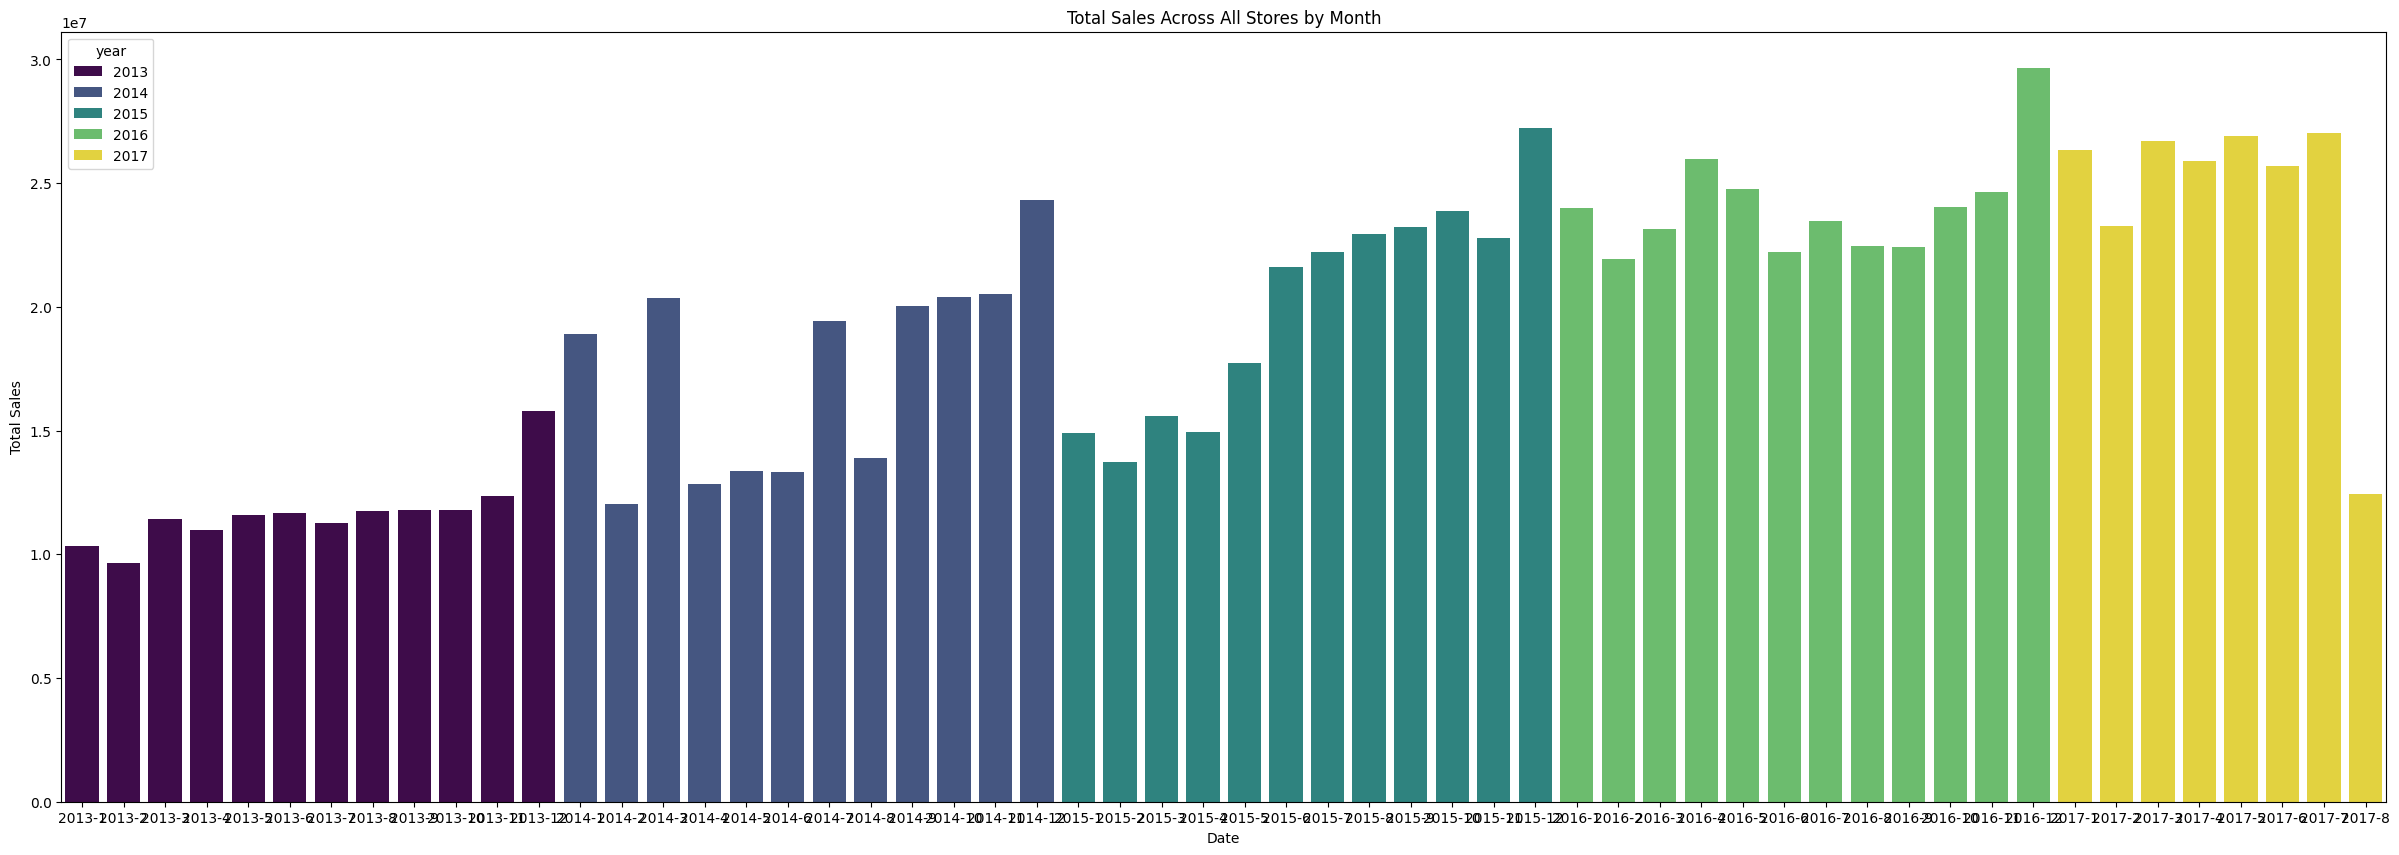

In [108]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Across All Stores by Month')
plt.show()

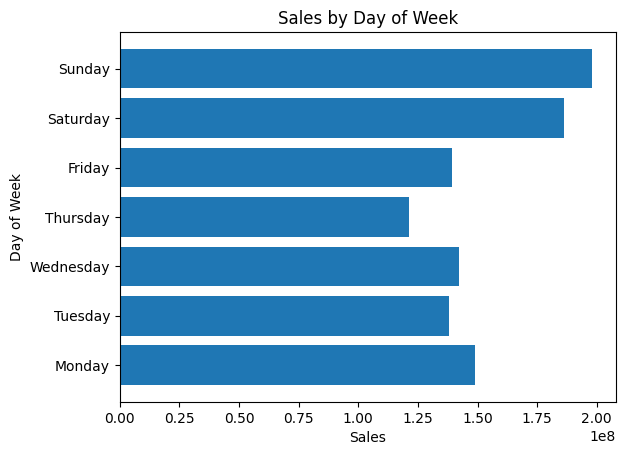

In [99]:
dow_sales = df_train.groupby('day_name')['sales'].sum().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_sales['day_name'] = pd.Categorical(dow_sales['day_name'], categories=day_order, ordered=True)
dow_sales.sort_values('day_name', inplace=True)

plt.barh(dow_sales['day_name'], dow_sales['sales'])
plt.xlabel('Sales')
plt.ylabel('Day of Week')
plt.title('Sales by Day of Week')
plt.show()

### there is significant seasonality across days of the week and months in the year. Ex. Sunday and December both usually will have high sales

## check for missing values

In [ ]:
### there are stores that werent open in 2013. it would be better to remove those rows

In [132]:
mindate = df_train[df_train['date']=='2013-01-01']
maxdate = df_train[df_train['date']=='2017-08-15']

print(mindate.shape[0], 'rows in the lowest date. ', maxdate.shape[0], 'rows in the max date')

1782 rows in the lowest date.  1782 rows in the max date


In [140]:
rows_per_day = df.groupby('date').size()
rows_per_day[rows_per_day!= 1782]

Series([], dtype: int64)

###  Every day has 1782 entries. That means that there are no missing values for id, store_nbr, or family. If there were no sales, the row will contain a 0 sales value

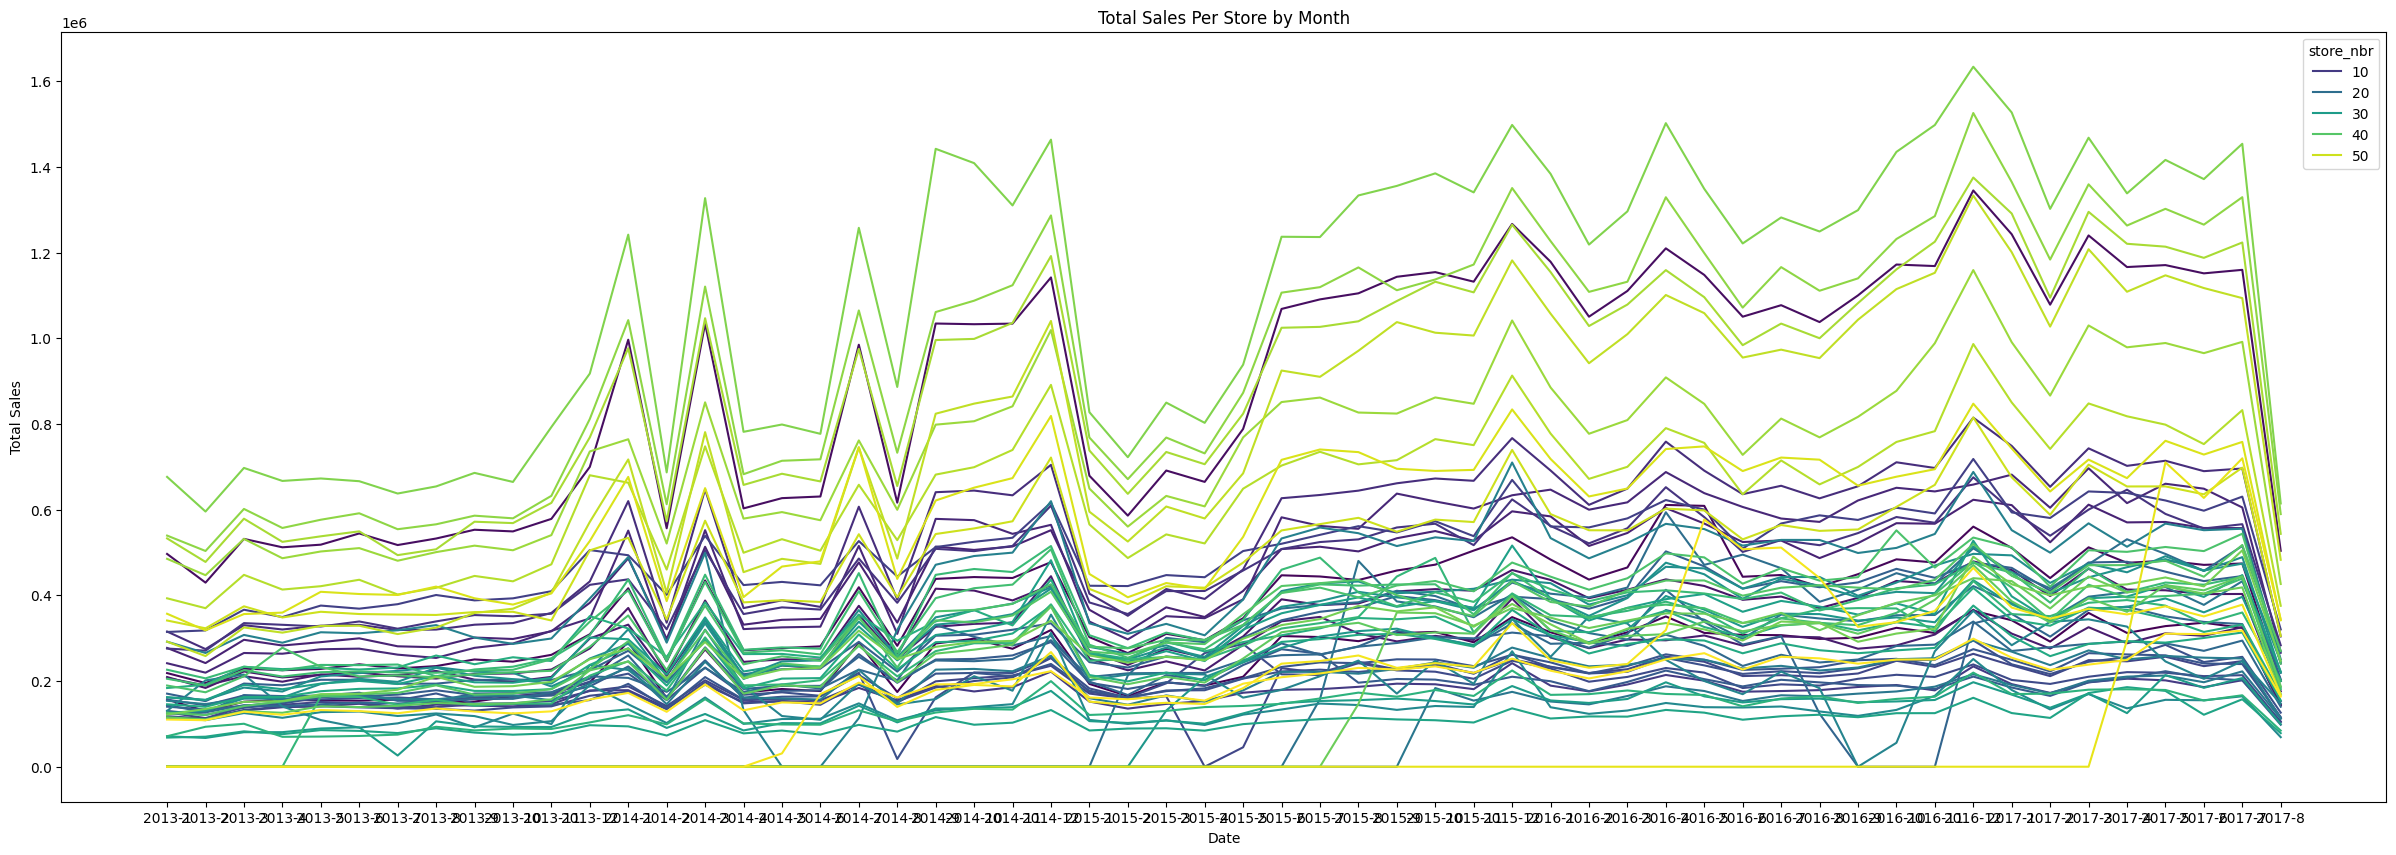

In [124]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.lineplot(x=df_monthly_sales_by_store['year'].astype(str)+'-'+df_monthly_sales_by_store['month'].astype(str), y='sales', hue='store_nbr', data=df_monthly_sales_by_store, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Per Store by Month')
plt.show()

In [ ]:
#check for stores and categories with 0 sales. remove those rows. 
#certain stores wont have opened in 2013 and certain store probably dont sell certain items?? bad assumption?
df_train.head()
unique_stores = df_train['store_nbr'].drop_duplicates().sort_values()
unique_stores.count()

In [146]:
first_sale_date_per_store = df_train[df_train['sales'] > 0].groupby('store_nbr')['date'].min().reset_index()
first_sale_date_per_store

store_nbr       date
0           1 2013-01-02
1           2 2013-01-02
2           3 2013-01-02
3           4 2013-01-02
4           5 2013-01-02
5           6 2013-01-02
6           7 2013-01-02
7           8 2013-01-02
8           9 2013-01-02
9          10 2013-01-02
10         11 2013-01-02
11         12 2013-01-02
12         13 2013-01-02
13         14 2013-01-02
14         15 2013-01-02
15         16 2013-01-02
16         17 2013-01-02
17         18 2013-01-02
18         19 2013-01-02
19         20 2015-02-13
20         21 2015-07-24
21         22 2015-10-09
22         23 2013-01-02
23         24 2013-01-02
24         25 2013-01-01
25         26 2013-01-02
26         27 2013-01-02
27         28 2013-01-02
28         29 2015-03-20
29         30 2013-01-02
30         31 2013-01-02
31         32 2013-01-02
32         33 2013-01-02
33         34 2013-01-02
34         35 2013-01-02
35         36 2013-05-09
36         37 2013-01-02
37         38 2013-01-02
38         39 2013-01-02
39         40 2013-01-02
40         41 2013-01-02
41         42 2015-08-21
42         43 2013-01-02
43         44 2013-01-02
44         45 2013-01-02
45         46 2013-01-02
46         47 2013-01-02
47         48 2013-01-02
48         49 2013-01-02
49         50 2013-01-02
50         51 2013-01-02
51         52 2017-04-20
52         53 2014-05-29
53         54 2013-01-02

In [152]:
df_train_min_date = pd.merge(df_train, first_sale_date_per_store, on='store_nbr')
df_train_shortened = df_train_min_date[df_train_min_date['date_x'] >= df_train_min_date['date_y']] 
df_train_shortened

id     date_x  store_nbr                      family     sales  \
33          1782 2013-01-02          1                  AUTOMOTIVE     2.000   
34          1783 2013-01-02          1                   BABY CARE     0.000   
35          1784 2013-01-02          1                      BEAUTY     2.000   
36          1785 2013-01-02          1                   BEVERAGES  1091.000   
37          1786 2013-01-02          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  month  year  day  week  day_of_week   day_name  \
33                 0      1  2013    2     1            2  Wednesday   
34                 0      1  2013    2     1            2  Wednesday   
35                 0      1  2013    2     1            2  Wednesday   
36                 0      1  2013    2     1            2  Wednesday   
37                 0      1  2013    2     1            2  Wednesday   
...              ...    ...   ...  ...   ...          ...        ...   
3000883            0      8  2017   15    33            1    Tuesday   
3000884            1      8  2017   15    33            1    Tuesday   
3000885          148      8  2017   15    33            1    Tuesday   
3000886            8      8  2017   15    33            1    Tuesday   
3000887            0      8  2017   15    33            1    Tuesday   

            date_y  
33      2013-01-02  
34      2013-01-02  
35      2013-01-02  
36      2013-01-02  
37      2013-01-02  
...            ...  
3000883 2013-01-02  
3000884 2013-01-02  
3000885 2013-01-02  
3000886 2013-01-02  
3000887 2013-01-02  

[2778831 rows x 13 columns]